In [2]:
import torch as th
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Pre-processing the dataset :-

In [3]:
data=pd.read_csv('data.csv')
data.drop(columns=['AppointmentID','AppointmentDay','Neighbourhood','ScheduledDay','PatientId'],inplace=True)
data['No-show']=data['No-show'].map({'No':0,'Yes':1})
data['Gender']=data['Gender'].map({'F':0,'M':1})
data['Age']=data['Age']/data['Age'].max()
data['Age']=data['Age'].astype(np.float32)

In [4]:
print(data.head())

   Gender       Age  Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  \
0       0  0.539130            0             1         0           0        0   
1       1  0.486957            0             0         0           0        0   
2       0  0.539130            0             0         0           0        0   
3       0  0.069565            0             0         0           0        0   
4       0  0.486957            0             1         1           0        0   

   SMS_received  No-show  
0             0        0  
1             0        0  
2             0        0  
3             0        0  
4             0        0  


Making the ANN using core python :- 

Task 1:-

In [5]:
data.shape

(110527, 9)

In [6]:
n_x=data.shape[1]-1
n_y=1
n_h=9
layer_dims=[n_x,n_h,n_y]

In [7]:
def sigmoid(x):
    cache=[]
    cache.append(x)
    return 1/(1+np.exp(-x)),cache

In [8]:
def relu(Z):
    cache=[]
    A=np.maximum(0,Z)
    cache.append(Z)
    return A,cache

In [9]:
def inipar(layer_dims):
    par={}
    np.random.seed(1)
    for l in range(1,len(layer_dims)):
        par['W'+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        par['b'+str(l)]=np.zeros((layer_dims[l],1))
    return par

In [10]:
def linfo(A,W,b):
    Z=np.dot(W,A)+b
    cache=(A,W,b)
    return Z,cache

In [11]:
def linactfow(A_prev,W,b,act):
    lin_cache=(A_prev,W,b)
    z=np.dot(W,A_prev)+b
    if act=='sigmoid':
        a,act_cache=sigmoid(z)
    elif act=='relu':
        a,act_cache=relu(z)
    cache=(lin_cache,act_cache)
    return a,cache

In [12]:
def Lmodfow(X,par):
    caches=[]
    A=X
    L=len(par)//2
    for l in range(1,L):
        aprev=A
        A,cache=linactfow(aprev,par['W'+str(l)],par['b'+str(l)],'relu')
        caches.append(cache)
    AL,cache=linactfow(A,par['W'+str(L)],par['b'+str(L)],'sigmoid')
    caches.append(cache)
    return AL,caches

In [13]:
def cost(AL,Y):
    m=Y.shape[1]
    cost=-1/m*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))
    cost=np.squeeze(cost)
    return cost

In [14]:
def linback(dZ,cache):
    A_prev,W,b=cache
    m=A_prev.shape[1]
    dW=1/m*np.dot(dZ,A_prev.T)
    db=1/m*np.sum(dZ,axis=1,keepdims=True)
    dA_prev=np.dot(W.T,dZ)
    return dA_prev,dW,db

In [15]:
def sigback(dA,cache):
    Z=cache[0]
    s=1/(1+np.exp(-Z))
    dZ=dA*s*(1-s)
    return dZ

In [16]:
def relback(dA,cache):
    Z=cache[0]
    dZ=np.array(dA,copy=True)
    dZ[Z<=0]=0
    return dZ

In [17]:
def linactback(dA,cache,act):
    lin_cache,act_cache=cache
    if act=='sigmoid':
        dZ=sigback(dA,act_cache)
    elif act=='relu':
        dZ=relback(dA,act_cache)
    dA_prev,dW,db=linback(dZ,lin_cache)
    return dA_prev,dW,db

In [18]:
def lmodback(AL,Y,caches):
    grads={}
    L=len(caches)
    m=AL.shape[1]
    Y=Y.reshape(AL.shape)
    dAL=-(np.divide(Y,AL)-np.divide(1-Y,1-AL))
    current_cache=caches[L-1]
    grads['dA'+str(L)],grads['dW'+str(L)],grads['db'+str(L)]=linactback(dAL,current_cache,'sigmoid')
    for l in reversed(range(L-1)):
        current_cache=caches[l]
        dA_prev_temp,dW_temp,db_temp=linactback(grads["dA" + str(l + 2)],current_cache,'relu')
        grads["dA"+str(l + 1)]=dA_prev_temp
        grads["dW"+str(l + 1)]=dW_temp
        grads["db"+str(l + 1)]=db_temp
    return grads

In [19]:
def updpar(par,grads,learnrate):
    L=len(par)//2
    for l in range(L):
        par['W'+str(l+1)]=par['W'+str(l+1)]-learnrate*grads['dW'+str(l+1)]
        par['b'+str(l+1)]=par['b'+str(l+1)]-learnrate*grads['db'+str(l+1)]
    return par

In [20]:
def Llaymod(X,Y,layer_dims,learnrate=0.01,num_iter=1000):
    np.random.seed(1)
    costs=[]
    par=inipar(layer_dims)
    for i in range(0,num_iter):
        AL,caches=Lmodfow(X,par)
        cst=cost(AL,Y)
        grads=lmodback(AL,Y,caches)
        par=updpar(par,grads,learnrate)
        if i%100==0:
            costs.append(cst)
            print("Cost after iteration %i: %f" % (i,cst))
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learnrate))
    plt.show()
    return par,costs

In [21]:
a=data.to_numpy()

In [22]:
print(a)

[[0.         0.53913045 0.         ... 0.         0.         0.        ]
 [1.         0.48695651 0.         ... 0.         0.         0.        ]
 [0.         0.53913045 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.18260869 0.         ... 0.         1.         0.        ]
 [0.         0.33043477 0.         ... 0.         1.         0.        ]
 [0.         0.46956521 0.         ... 0.         1.         0.        ]]


In [23]:
print(data.head())

   Gender       Age  Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  \
0       0  0.539130            0             1         0           0        0   
1       1  0.486957            0             0         0           0        0   
2       0  0.539130            0             0         0           0        0   
3       0  0.069565            0             0         0           0        0   
4       0  0.486957            0             1         1           0        0   

   SMS_received  No-show  
0             0        0  
1             0        0  
2             0        0  
3             0        0  
4             0        0  


In [24]:
X=a[:,0:8].T
Y=a[:,8].reshape(1,a.shape[0])

In [25]:
print(X.shape)
print(Y.shape)

(8, 110527)
(1, 110527)


Cost after iteration 0: 0.693174
Cost after iteration 100: 0.623113
Cost after iteration 200: 0.580274
Cost after iteration 300: 0.553621
Cost after iteration 400: 0.536704
Cost after iteration 500: 0.525756
Cost after iteration 600: 0.518547
Cost after iteration 700: 0.513730
Cost after iteration 800: 0.510469
Cost after iteration 900: 0.508239


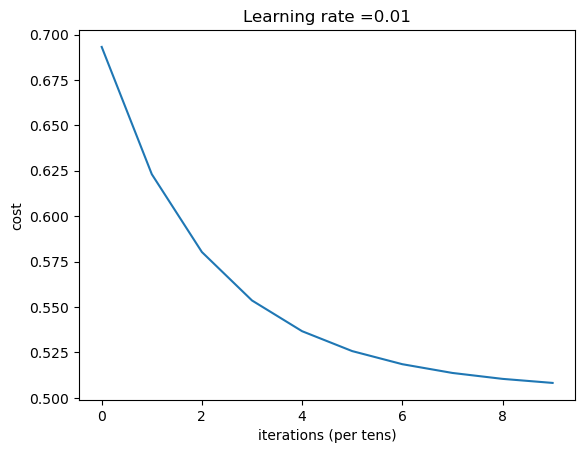

In [26]:
par,costs=Llaymod(X,Y,layer_dims,learnrate=0.01,num_iter=1000)

In [27]:
def predict(tx,ty,par):
    m=tx.shape[1]
    p=np.zeros((1,m))
    AL,caches=Lmodfow(tx,par)
    for i in range(0,AL.shape[1]):
        if AL[0,i]>0.5:
            p[0,i]=1
        else:
            p[0,i]=0
    print("Accuracy: "  + str(np.sum((p==ty)/m)))
    return p

In [28]:
pt=predict(X,Y,par)

Accuracy: 0.7980674405348921


Now using PyTorch for this :- 

Part 2:-

In [29]:
import torch.nn as nn
import torch.optim as optim
import torch

In [30]:
class ANN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(ANN,self).__init__()
        self.fc1=nn.Linear(input_size,hidden_size)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(hidden_size,output_size)

    def forward(self,x):
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        return x

In [31]:
n_x=data.shape[1]-1
n_h=9
n_y=1

model=ANN(n_x,n_h,n_y)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [32]:
X_train=th.from_numpy(X.T).float()
y_train=th.from_numpy(Y.T).float()

In [34]:
for epoch in range(1000):  # number of training epochs
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 0.1574
Epoch [20/1000], Loss: 0.1574
Epoch [30/1000], Loss: 0.1574
Epoch [40/1000], Loss: 0.1574
Epoch [50/1000], Loss: 0.1574
Epoch [60/1000], Loss: 0.1574
Epoch [70/1000], Loss: 0.1574
Epoch [80/1000], Loss: 0.1574
Epoch [90/1000], Loss: 0.1574
Epoch [100/1000], Loss: 0.1574
Epoch [110/1000], Loss: 0.1574
Epoch [120/1000], Loss: 0.1574
Epoch [130/1000], Loss: 0.1574
Epoch [140/1000], Loss: 0.1574
Epoch [150/1000], Loss: 0.1574
Epoch [160/1000], Loss: 0.1574
Epoch [170/1000], Loss: 0.1574
Epoch [180/1000], Loss: 0.1574
Epoch [190/1000], Loss: 0.1574
Epoch [200/1000], Loss: 0.1574
Epoch [210/1000], Loss: 0.1574
Epoch [220/1000], Loss: 0.1574
Epoch [230/1000], Loss: 0.1574
Epoch [240/1000], Loss: 0.1574
Epoch [250/1000], Loss: 0.1574
Epoch [260/1000], Loss: 0.1574
Epoch [270/1000], Loss: 0.1574
Epoch [280/1000], Loss: 0.1574
Epoch [290/1000], Loss: 0.1574
Epoch [300/1000], Loss: 0.1574
Epoch [310/1000], Loss: 0.1574
Epoch [320/1000], Loss: 0.1574
Epoch [330/1000],